In [1]:
from src.utils.conf_utils import get_cfg
from src.models.partmae_v2_module import PARTModule
import timm
import hydra
from src.callbacks.loggers.pretrain.reconstruction_v3 import ReconstructionLogger
import torch
from collections import defaultdict
from src.utils.analysis.hooked_vit import HookedViT

In [2]:
cfg = get_cfg(
    [
        "experiment=pretrain/imagenet1k/partmae_v2/vit_b_16/4060ti",
        "data.batch_size=4",
        "data.num_workers=0",
    ]
)

In [3]:
module = PARTModule.load_from_checkpoint("../../artifacts/model-oj0seccv:v0/last.ckpt")

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [4]:
datamodule = hydra.utils.instantiate(cfg.data)

INFO:datasets:PyTorch version 2.7.0.dev20250122+cu126 available.
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'train_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['train_transform'])`.
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'test_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['test_transform'])`.


In [5]:
datamodule.setup()
train_dataloader = datamodule.test_dataloader()
train_batch = next(iter(train_dataloader))
train_batch = datamodule.transfer_batch_to_device(train_batch, "cuda", 0)

INFO:HFDataModule:Loading datasets.


Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:HFDataModule:Finished setting up datasets.


In [6]:
module.net.update_conf(sampler="stratified_jittered")
with torch.no_grad():
    output = module.model_step(train_batch)

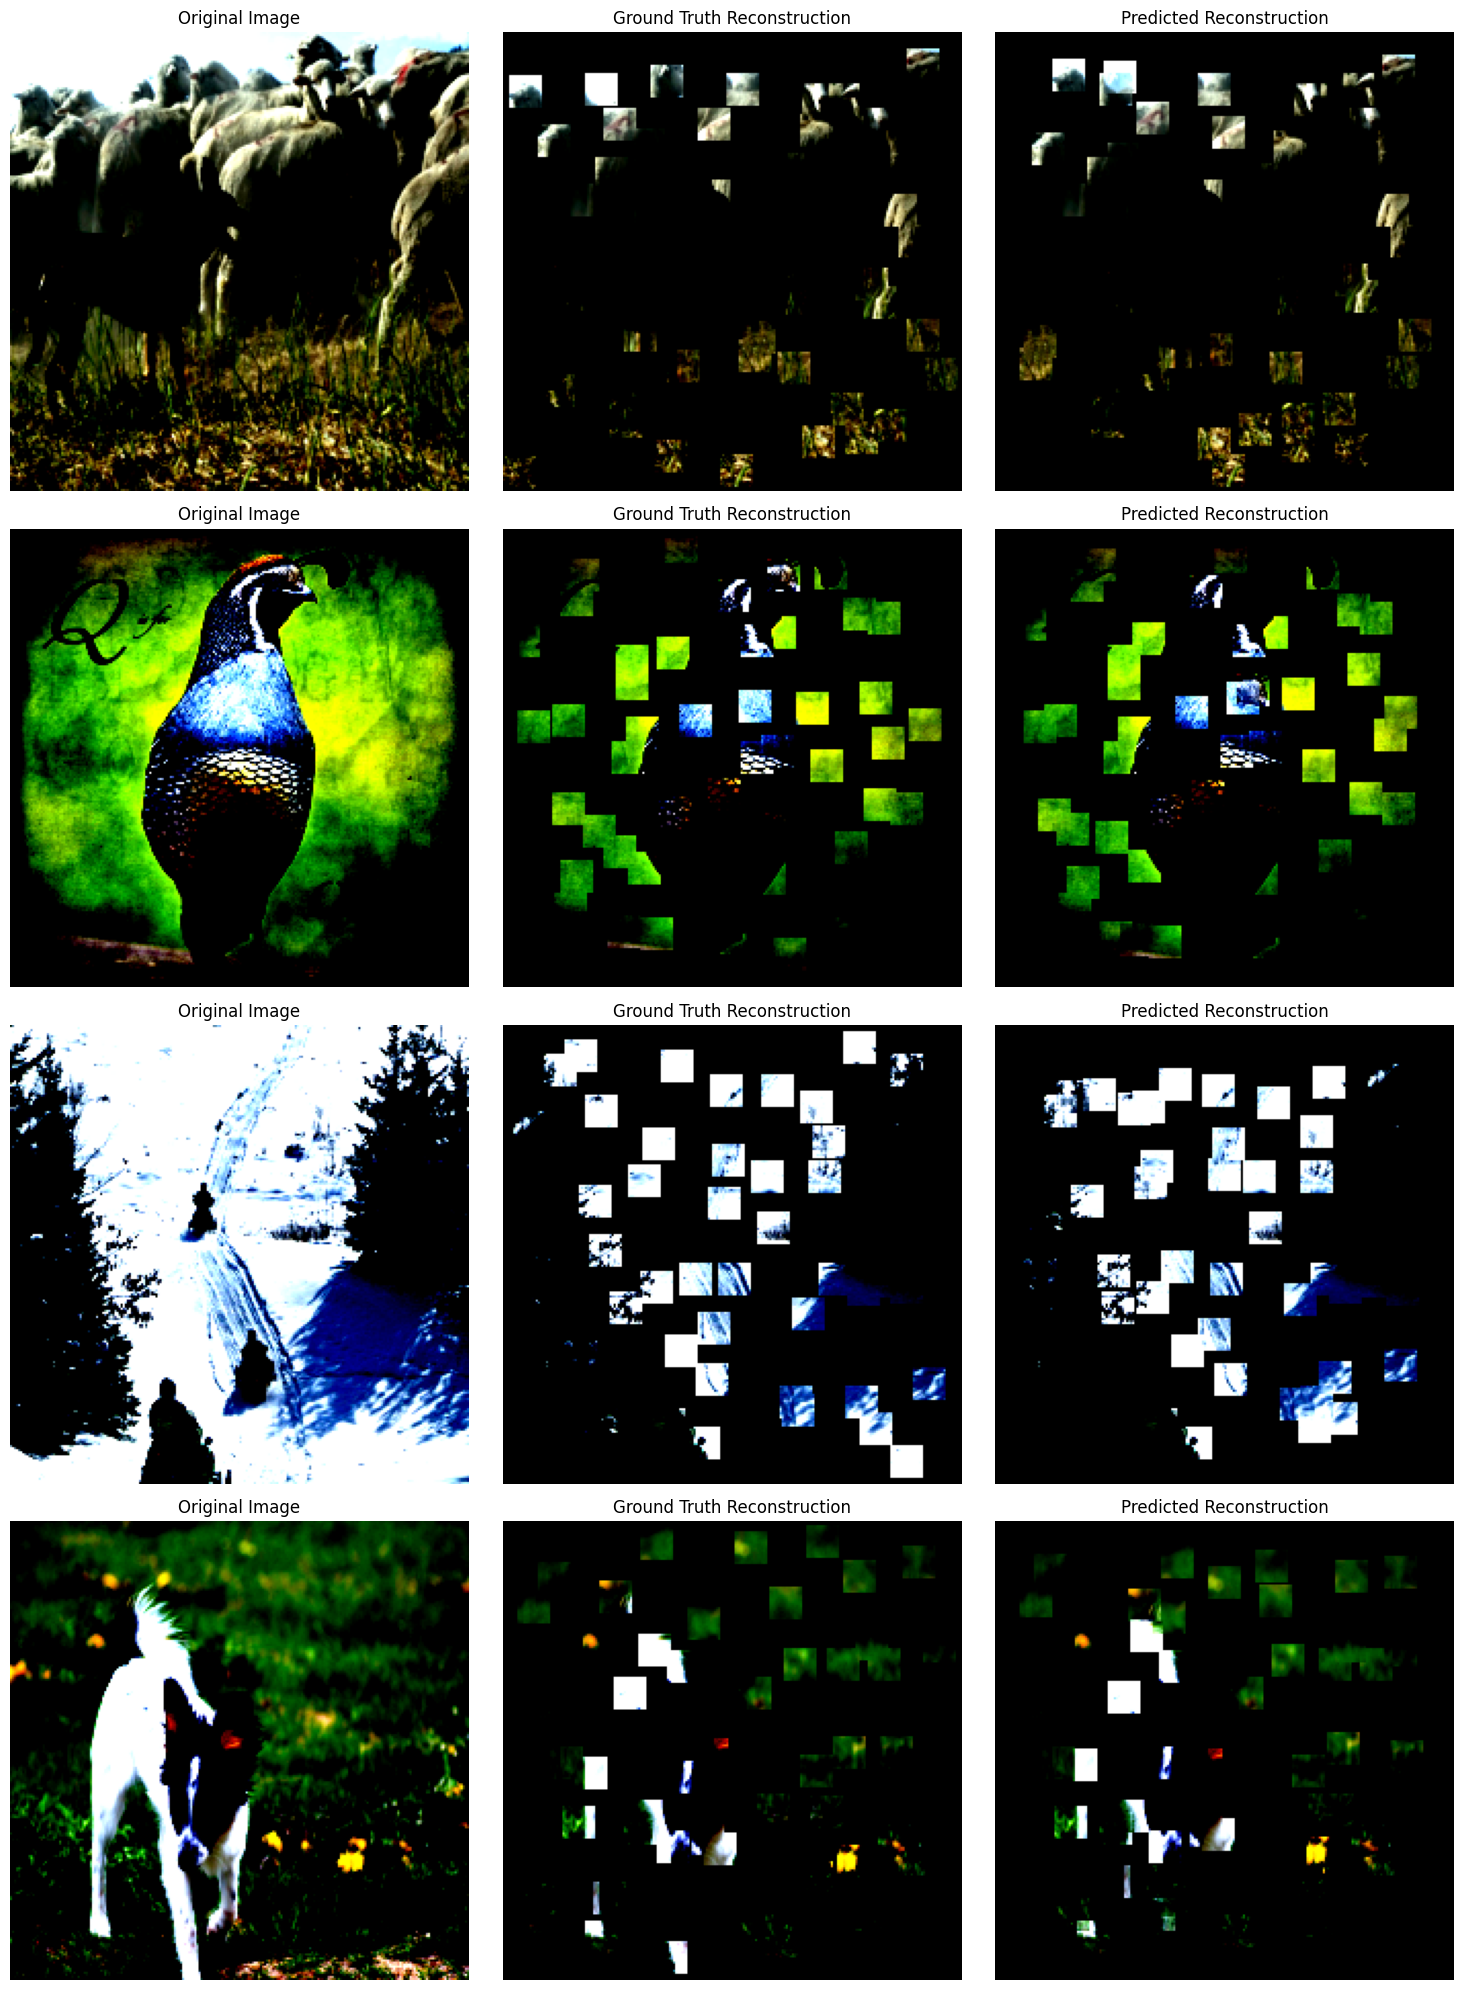

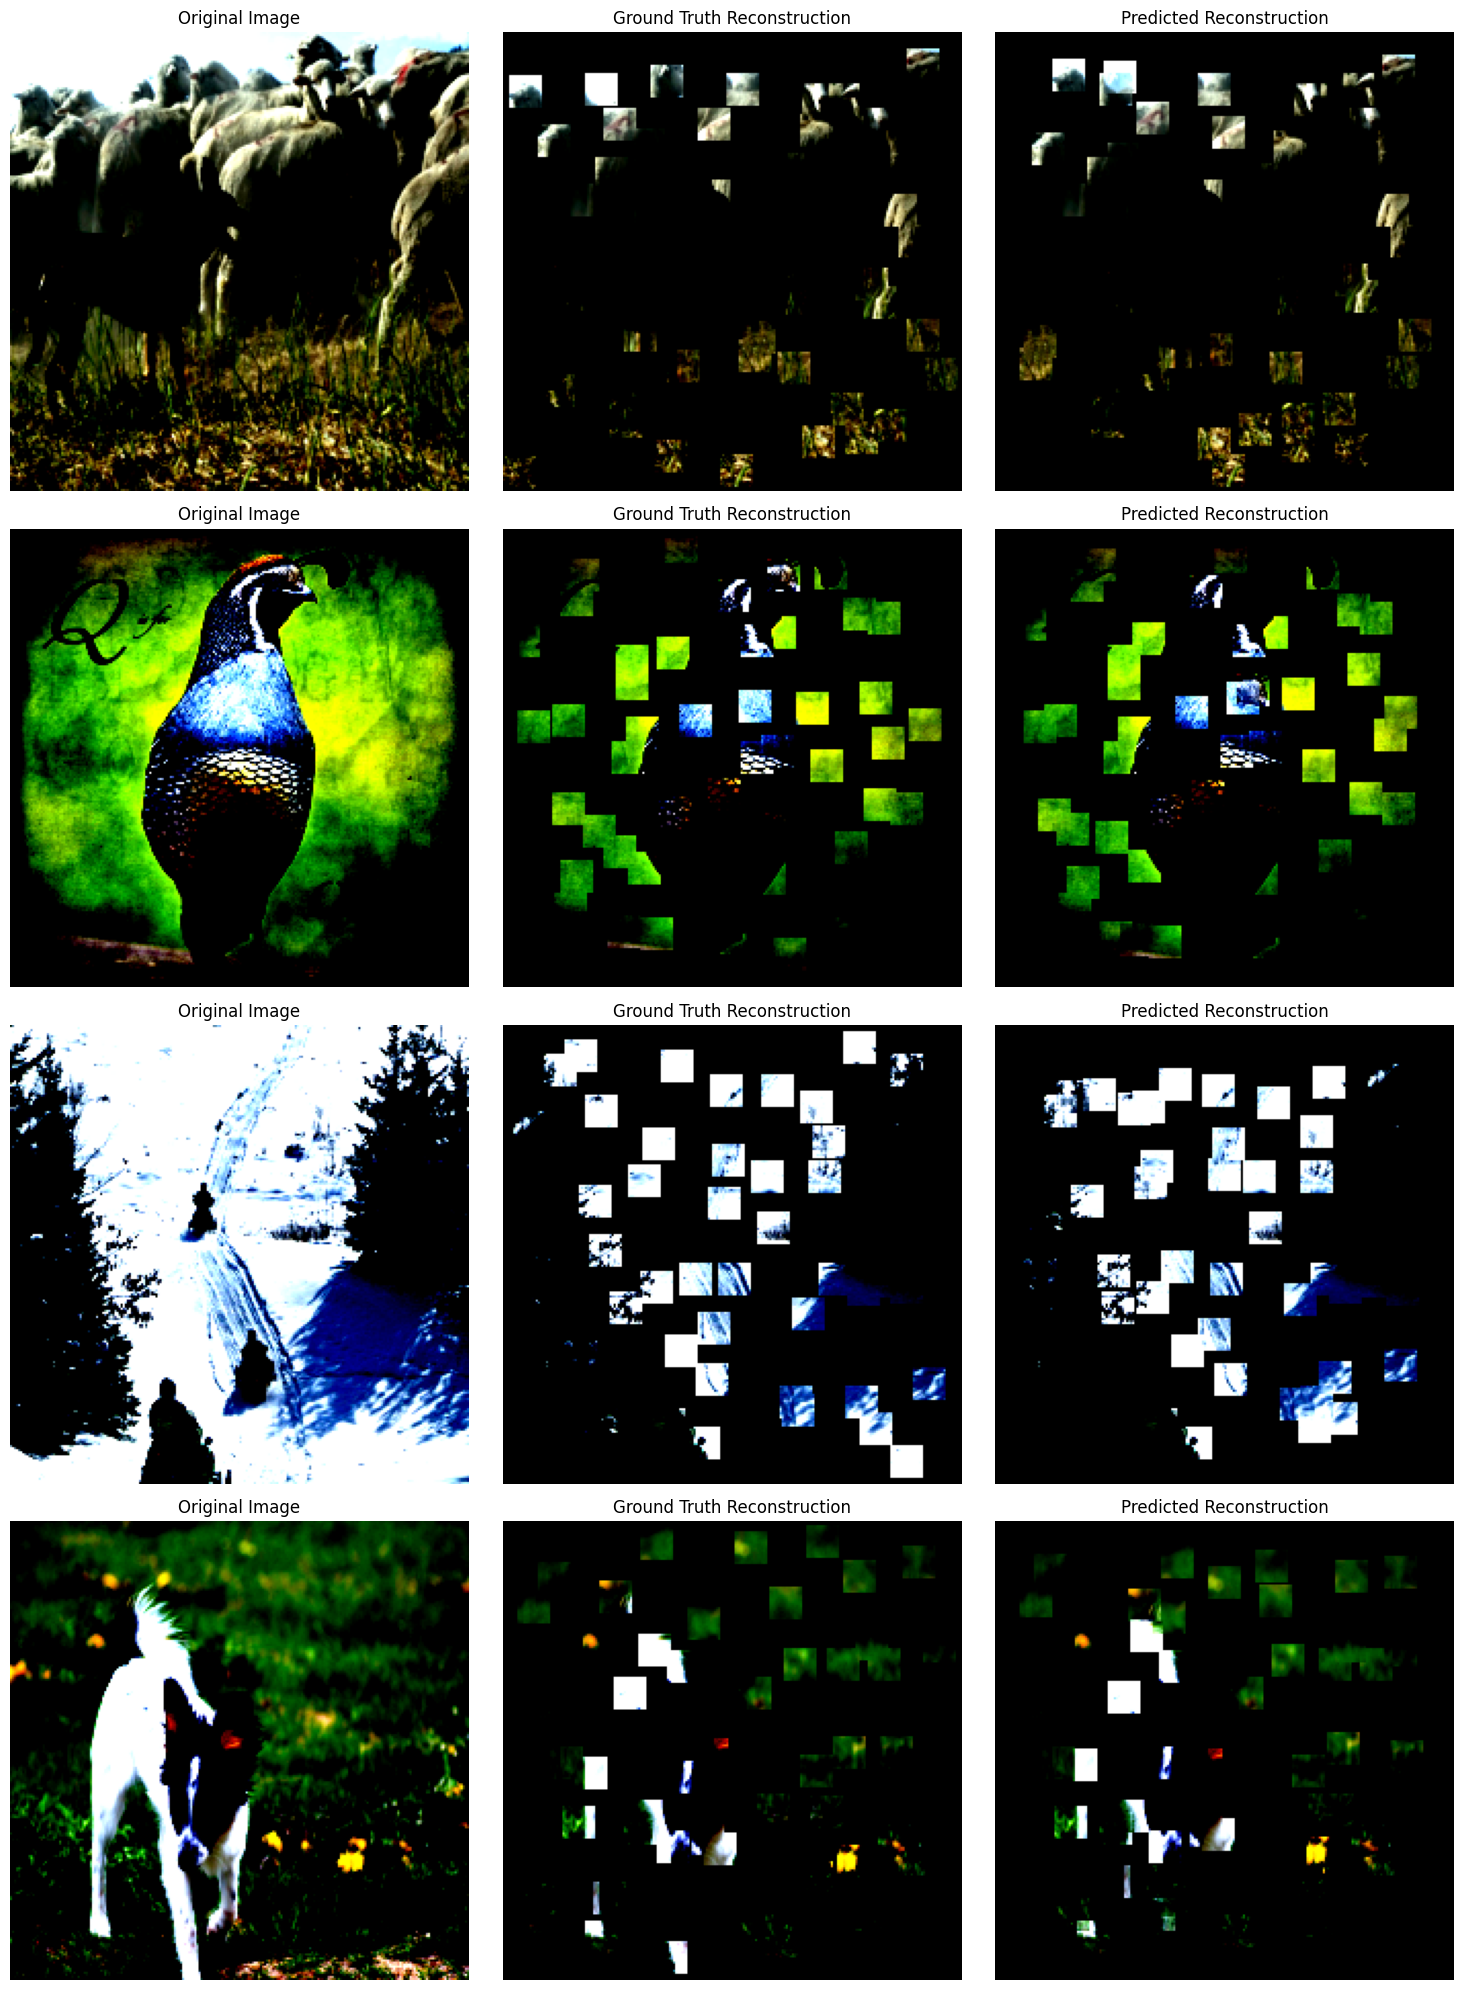

In [7]:
rec = ReconstructionLogger(num_samples=4)

rec._plot(
    module,
    img=train_batch["image"],
    patch_positions_vis=output["patch_positions_vis"],
    pred_T=output["pred_T"],
    patch_pair_indices=output["patch_pair_indices"],
    ids_remove_pos=output["ids_remove_pos"],
)

## export to backbone

In [8]:
module.state_dict().keys()

odict_keys(['net.cls_token', 'net.pos_embed', 'net.mask_pos_token', 'net.patch_embed.proj.weight', 'net.patch_embed.proj.bias', 'net.blocks.0.norm1.weight', 'net.blocks.0.norm1.bias', 'net.blocks.0.attn.qkv.weight', 'net.blocks.0.attn.qkv.bias', 'net.blocks.0.attn.proj.weight', 'net.blocks.0.attn.proj.bias', 'net.blocks.0.norm2.weight', 'net.blocks.0.norm2.bias', 'net.blocks.0.mlp.fc1.weight', 'net.blocks.0.mlp.fc1.bias', 'net.blocks.0.mlp.fc2.weight', 'net.blocks.0.mlp.fc2.bias', 'net.blocks.1.norm1.weight', 'net.blocks.1.norm1.bias', 'net.blocks.1.attn.qkv.weight', 'net.blocks.1.attn.qkv.bias', 'net.blocks.1.attn.proj.weight', 'net.blocks.1.attn.proj.bias', 'net.blocks.1.norm2.weight', 'net.blocks.1.norm2.bias', 'net.blocks.1.mlp.fc1.weight', 'net.blocks.1.mlp.fc1.bias', 'net.blocks.1.mlp.fc2.weight', 'net.blocks.1.mlp.fc2.bias', 'net.blocks.2.norm1.weight', 'net.blocks.2.norm1.bias', 'net.blocks.2.attn.qkv.weight', 'net.blocks.2.attn.qkv.bias', 'net.blocks.2.attn.proj.weight', 'net.

In [9]:
vit = timm.create_model(
    "vit_base_patch16_224", pretrained=False, num_classes=0, global_pool=""
).cuda()
state_dict = module.net.state_dict()
# invert the patch embedding
# currently the patch embedding is using linear projection, we need to reshape it to a conv2d projection
# (768, 768) -> (768, 3, 16, 16)
state_dict["patch_embed.proj.weight"] = state_dict["patch_embed.proj.weight"].reshape(
    768, 3, 16, 16
)
state_dict["pos_embed"] = torch.cat(
    [
        state_dict["pos_embed"][:, 0:1, :],
        state_dict["pos_embed"][0, 1:, :]
        .reshape(14, 14, -1)
        .transpose(0, 1)
        .flatten(0, 1)
        .unsqueeze(0),
    ],
    dim=1,
)

# remove all the keys that start with "decoder_"
state_dict = {k: v for k, v in state_dict.items() if not k.startswith("decoder_")}
# remove mask_pos_token
state_dict.pop("mask_pos_token")
vit.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [28]:
# save vit to ../../artifacts/model-oj0seccv:v0/backbone.ckpt
torch.save(vit.state_dict(), "../../artifacts/model-oj0seccv:v0/backbone.ckpt")

In [10]:
print(state_dict["pos_embed"][:, 0:1, :].shape)
print(state_dict["pos_embed"][0, 1:, :].reshape(14, 14, -1).transpose(0, 1).flatten(0, 1).unsqueeze(0).shape)

torch.Size([1, 1, 768])
torch.Size([1, 196, 768])


In [11]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
# hook vit.patch_embed
from timm.models.vision_transformer import VisionTransformer
hooked_vit = HookedViT(vit)
hooked_vit.hook_layer('patch_embed')
torch.manual_seed(0)
with torch.no_grad():
    vit_out = hooked_vit(train_batch["image"])

In [13]:
module.net.update_conf(sampler="ongrid_canonical", mask_ratio=0.0, pos_mask_ratio=0.0)
hooked_net = HookedViT(module.net, 'tanh')
hooked_net.hook_layer('patch_embed')
torch.manual_seed(0)
with torch.no_grad():
    net_out = hooked_net(train_batch["image"])

In [14]:
net_pe_out = hooked_net.cache["patch_embed"]["output"][0]
vit_pe_out = hooked_vit.cache["patch_embed"]["output"]

In [15]:
torch.set_printoptions(precision=4, profile='short', sci_mode=False)
print(net_pe_out.shape)
print(vit_pe_out.shape)
print(vit_pe_out[0, :4, :5])
print(net_pe_out[0, :4, :5])
# get distribution of errors
errors = torch.abs(net_pe_out[0] - vit_pe_out[0])
# reshape to img
print(errors.shape)
print(errors.mean(), errors.std(), errors.max(), errors.median())

torch.Size([4, 196, 768])
torch.Size([4, 196, 768])
tensor([[    -0.1074,      0.0801,      0.0001,     -0.1378,     -0.1229],
        [    -0.1082,      0.0992,     -0.0020,     -0.1524,     -0.1181],
        [    -0.0982,      0.1513,      0.0401,     -0.2065,     -0.0830],
        [     0.0051,      0.2118,      0.0440,     -0.1282,     -0.1110]])
tensor([[-0.1081,  0.0809, -0.0005, -0.1374, -0.1230],
        [-0.1092,  0.0988, -0.0021, -0.1523, -0.1179],
        [-0.0990,  0.1509,  0.0390, -0.2065, -0.0833],
        [ 0.0035,  0.2126,  0.0438, -0.1291, -0.1114]])
torch.Size([196, 768])
tensor(0.0002) tensor(0.0003) tensor(0.0054) tensor(0.0001)


In [16]:
print(hooked_net.cache["blocks.0"]["input"][0].shape)
print(hooked_vit.cache["blocks.0"]["input"][0].shape)
print(hooked_net.cache["blocks.0"]["input"][0][0, 1:4, :6])
print(hooked_vit.cache["blocks.0"]["input"][0][0, 1:4, :6])
errors = torch.abs(hooked_net.cache["blocks.0"]["input"][0] - hooked_vit.cache["blocks.0"]["input"][0])
print(errors.mean(), errors.std(), errors.max(), errors.median())

torch.Size([4, 197, 768])
torch.Size([4, 197, 768])
tensor([[-0.1081,  0.0809, -0.0005, -0.1374, -0.1230,  0.0981],
        [-0.1092,  0.0988, -0.0021, -0.1523, -0.1179,  0.1134],
        [-0.0990,  0.1509,  0.0390, -0.2065, -0.0833,  0.1995]])
tensor([[    -0.1074,      0.0801,      0.0001,     -0.1378,     -0.1229,
              0.0984],
        [    -0.1082,      0.0992,     -0.0020,     -0.1524,     -0.1181,
              0.1129],
        [    -0.0982,      0.1513,      0.0401,     -0.2065,     -0.0830,
              0.1983]])
tensor(0.0003) tensor(0.0003) tensor(0.0054) tensor(0.0002)


In [17]:
print(net_out["out"]["z"].shape)
print(vit_out["out"].shape)
print(net_out["out"]["z"][0, :4, :10])
print(vit_out["out"][0, :4, :10])
errors = torch.abs(net_out["out"]["z"] - vit_out["out"])
print(errors.mean(), errors.std(), errors.max(), errors.median())

torch.Size([4, 197, 768])
torch.Size([4, 197, 768])
tensor([[ 0.1370,  0.2086, -0.2063,  0.2914,  0.2092, -0.0397, -0.1247,  0.1489,
          0.2280, -0.2425],
        [ 0.0643, -0.0768, -0.0391, -0.3839, -0.2437,  0.2026, -0.0476,  0.2323,
         -0.0483, -0.1126],
        [ 0.1184, -0.0917,  0.0326, -0.4009, -0.2772,  0.2279, -0.0697,  0.1892,
         -0.0019, -0.0844],
        [-0.0183, -0.0016,  0.1138, -0.3737, -0.2299,  0.1337, -0.0660,  0.0937,
         -0.0194,  0.0318]], device='cuda:0')
tensor([[ 0.1370,  0.2086, -0.2064,  0.2914,  0.2092, -0.0397, -0.1247,  0.1490,
          0.2280, -0.2425],
        [ 0.0647, -0.0770, -0.0386, -0.3837, -0.2444,  0.2030, -0.0476,  0.2321,
         -0.0481, -0.1116],
        [ 0.1181, -0.0909,  0.0321, -0.4012, -0.2766,  0.2282, -0.0699,  0.1899,
         -0.0028, -0.0840],
        [-0.0185, -0.0013,  0.1132, -0.3732, -0.2298,  0.1335, -0.0656,  0.0945,
         -0.0197,  0.0318]], device='cuda:0')
tensor(    0.0001, device='cuda:0') tens

In [18]:
vit.pos_embed[0, 1:, :].reshape(14, 14, -1).transpose(0, 1).flatten(0, 1)[:4, :5]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8415, 0.8153, 0.7886, 0.7617, 0.7348],
        [0.9093, 0.9442, 0.9698, 0.9870, 0.9968],
        [0.1411, 0.2784, 0.4041, 0.5173, 0.6174]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [19]:
print(net_out["out"]["pos_embed"][0, :4, :5])
print(vit.pos_embed[0, 1:5, :5])

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0', grad_fn=<SliceBackward0>)


In [20]:
from src.models.components.utils.offgrid_pos_embed import get_2d_sincos_pos_embed, get_canonical_coords
from src.models.components.utils.patch_embed import ongrid_sampling_canonical

B =  4
H = W = 224
P = 16
G = H // P
N = G ** 2
D = 768
assert N == 196
ys, xs = ongrid_sampling_canonical(1, H, W, P, N, 'cuda')
pos = torch.stack([xs, ys], dim=-1)
coords = get_canonical_coords((G, G), P, 'cuda')
pos_embed = get_2d_sincos_pos_embed(
    pos.flatten(0, 1) / P, D
)
pos_embed_coords = get_2d_sincos_pos_embed(
    coords / P, D
)
pos_embed = pos_embed.unflatten(0, (1, N))

In [21]:
pos[0 , :10]

tensor([[  0,   0],
        [ 16,   0],
        [ 32,   0],
        [ 48,   0],
        [ 64,   0],
        [ 80,   0],
        [ 96,   0],
        [112,   0],
        [128,   0],
        [144,   0]], device='cuda:0')

In [22]:
coords[:10]

tensor([[  0.,   0.],
        [ 16.,   0.],
        [ 32.,   0.],
        [ 48.,   0.],
        [ 64.,   0.],
        [ 80.,   0.],
        [ 96.,   0.],
        [112.,   0.],
        [128.,   0.],
        [144.,   0.]], device='cuda:0')

In [23]:
pos_embed[0, :10, :5]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.8153,  0.7886,  0.7617,  0.7348],
        [ 0.9093,  0.9442,  0.9698,  0.9870,  0.9968],
        [ 0.1411,  0.2784,  0.4041,  0.5173,  0.6174],
        [-0.7568, -0.6218, -0.4728, -0.3167, -0.1593],
        [-0.9589, -0.9986, -0.9856, -0.9277, -0.8335],
        [-0.2794, -0.5348, -0.7393, -0.8854, -0.9713],
        [ 0.6570,  0.3792,  0.0764, -0.2196, -0.4841],
        [ 0.9894,  0.9740,  0.8332,  0.6008,  0.3146],
        [ 0.4121,  0.7488,  0.9484,  0.9982,  0.9109]], device='cuda:0')

In [24]:
pos_embed_coords[:10, :5]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.8153,  0.7886,  0.7617,  0.7348],
        [ 0.9093,  0.9442,  0.9698,  0.9870,  0.9968],
        [ 0.1411,  0.2784,  0.4041,  0.5173,  0.6174],
        [-0.7568, -0.6218, -0.4728, -0.3167, -0.1593],
        [-0.9589, -0.9986, -0.9856, -0.9277, -0.8335],
        [-0.2794, -0.5348, -0.7393, -0.8854, -0.9713],
        [ 0.6570,  0.3792,  0.0764, -0.2196, -0.4841],
        [ 0.9894,  0.9740,  0.8332,  0.6008,  0.3146],
        [ 0.4121,  0.7488,  0.9484,  0.9982,  0.9109]], device='cuda:0')

In [25]:
from timm.models.vision_transformer import VisionTransformer

In [26]:
print(vit.cls_token[0, 0, :5])
print(module.net.cls_token[0, 0, :5])

tensor([-0.0181,  0.0454, -0.0030, -0.0198, -0.0193], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([-0.0181,  0.0454, -0.0030, -0.0198, -0.0193], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [27]:
print(vit.pos_embed[0, :3, :10])
print(module.net.pos_embed[0, :3, :10])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.8415, 0.8153, 0.7886, 0.7617, 0.7348, 0.7081, 0.6816, 0.6554, 0.6298,
         0.6047]], device='cuda:0')
